# QCD estimate from same-sign muon/electron+tau events

It is useful to construct a same-sign region for estimating the background due to multijet QCD in the $\mu+\tau_{h}$ channel.  We estimate this background using the fake rate method so this can be used as a cross-check or a replacement.  This method is used in the measurement of the $\tau_{h}$ efficiencies which I would like to recreate so that the measurement can be carried out _in situ_ and the uncertainty sources are not double counted.

In [20]:
# import and global set up
%cd '/home/naodell/work/wbr/analysis'
%matplotlib notebook
%pwd

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import scripts.plot_tools as pt
pt.set_default_style()

%matplotlib inline
%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 36169,
  "iopub_port": 35533,
  "stdin_port": 35945,
  "control_port": 53329,
  "hb_port": 58791,
  "ip": "127.0.0.1",
  "key": "943827bb-ab6d55b71b39076832fcde8f",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-f84d795d-b258-470c-9b35-f4cf67abd03c.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [21]:
# get the data
# set up and get the data
selection = 'etau'
cuts = 'lepton2_pt > 20 and trigger_status == 1 and dilepton1_mass > 20'# and n_jets < 2 and n_bjets == 0'
if selection == 'mutau':
    labels = ['muon']
    cuts = cuts + ' and lepton1_pt > 25'
elif selection == 'etau':
    labels = ['electron']
    cuts = cuts + ' and lepton1_pt > 30'
labels += ['t', 'ttbar', 'wjets', 'zjets_alt']#, 'diboson']

dm = pt.DataManager(input_dir     = f'local_data/flatuples/updated_e_sf/{selection}_2016',
                    dataset_names = [d for l in labels for d in pt.dataset_dict[l]],
                    selection     = selection,
                    period        = 2016,
                    scale         = 35.9e3,
                    cuts          = f'{cuts}'#' and n_bjets == 0  and n_jets < 2'
                                     #and p_miss_zeta - 0.85*p_vis_zeta > -25 \
                                     #and 40 < dilepton1_mass < 100'
                                     #and lepton1_mt < 40 \
                   )
df_data_os  = dm.get_dataframe('data').query('lepton1_q != lepton2_q')
df_ttbar_os = dm.get_dataframe('ttbar').query('lepton1_q != lepton2_q')
df_top_os   = dm.get_dataframe('t').query('lepton1_q != lepton2_q')
df_z_os     = dm.get_dataframe('zjets_alt').query('lepton1_q != lepton2_q')
df_w_os     = dm.get_dataframe('wjets').query('lepton1_q != lepton2_q')
#df_vv_os    = dm.get_dataframe('diboson').query('lepton1_q != lepton2_q')

df_data_ss  = dm.get_dataframe('data').query('lepton1_q == lepton2_q').copy()
df_ttbar_ss = dm.get_dataframe('ttbar').query('lepton1_q == lepton2_q').copy()
df_top_ss   = dm.get_dataframe('t').query('lepton1_q == lepton2_q').copy()
df_z_ss     = dm.get_dataframe('zjets_alt').query('lepton1_q == lepton2_q').copy()
df_w_ss     = dm.get_dataframe('wjets').query('lepton1_q == lepton2_q').copy()
#df_vv_ss    = dm.get_dataframe('diboson').query('lepton1_q == lepton2_q').copy()

Loading dataframes: 100%|███████████████| 19.0/19.0 [00:03<00:00, 4.43it/s]


550.5088555146048 981.7479759278626 1125.561676781177
357.4562910343025 529.3578357243531 638.7446424376265


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


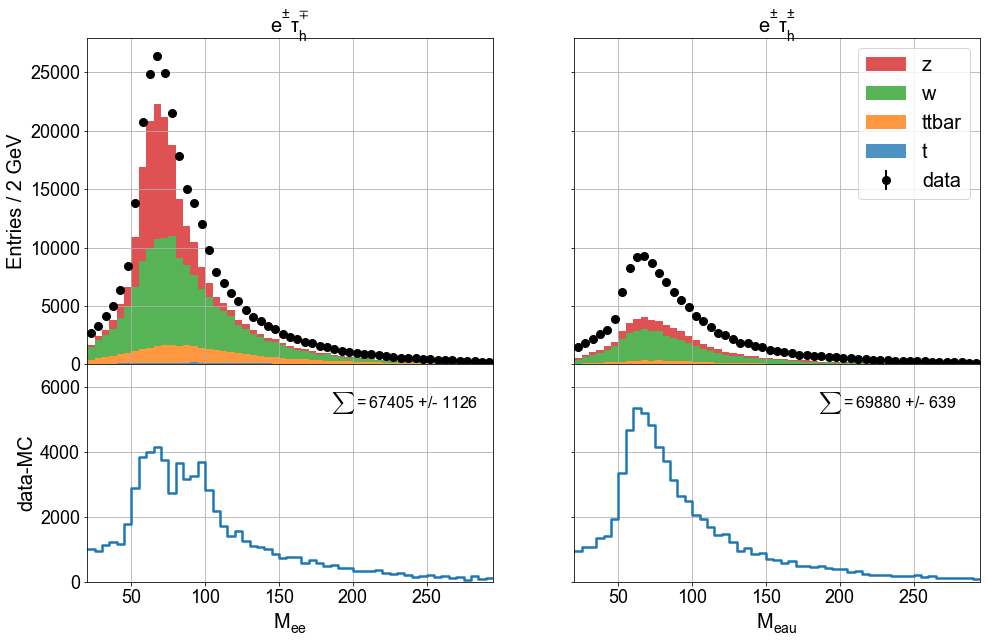

In [22]:
# compare the OS and SS control regions
fig, axes = plt.subplots(2, 2, figsize=(16, 10), facecolor='white', gridspec_kw={'height_ratios':[3,2]}, sharex='col', sharey='row')
fig.subplots_adjust(hspace=0)

var = 'dilepton1_mass'
bins = np.arange(20, 300, 5)

ax = axes[0][0]
x, y, yerr = pt.hist_to_errorbar(df_data_os[var], bins = bins)
ax.errorbar(x, y, yerr, fmt='ko', capsize=0, elinewidth=2)
h_mc, _, _ = ax.hist([df_top_os[var], df_ttbar_os[var], df_w_os[var], df_z_os[var]], 
                     bins=bins, 
                     histtype='stepfilled', 
                     alpha=0.8, 
                     weights=[df_top_os['weight'], df_ttbar_os['weight'], df_w_os['weight'], df_z_os['weight']], 
                     stacked=True 
                    )

var_mc, _ = np.histogram(np.concatenate([df_top_os[var], df_ttbar_os[var], df_w_os[var], df_z_os[var]]), 
                     bins=bins, 
                     weights=np.concatenate([df_top_os['weight']**2, df_ttbar_os['weight']**2, df_w_os['weight']**2, df_z_os['weight']**2]), 
                     )
err_data, err_mc = np.sqrt(np.sum(yerr**2)), np.sqrt(var_mc.sum())
err_total = np.sqrt(err_data**2 + err_mc**2)
print(err_data, err_mc, err_total)

ax.grid()
ax.set_ylabel('Entries / 2 GeV')
ax.set_xlim(bins.min(), bins.max())
if selection == 'mutau':
    ax.set_title(r'$\mu^{\pm}\tau^{\mp}_{h}$', fontsize = 20)
elif selection == 'etau':
    ax.set_title(r'$e^{\pm}\tau^{\mp}_{h}$', fontsize = 20)
    

ax = axes[1][0]
h_data, _ = np.histogram(df_data_os[var], bins=bins)
diff = y - h_mc[-1]
diff_os_iso = np.append(diff, diff[-1])
ax.plot(bins, diff_os_iso, drawstyle='steps-post')
ax.text(0.6, 0.8, r'$\sum =$' + f'{diff.sum():.0f} +/- {err_total:.0f}', size = 16, transform = ax.transAxes)
ax.set_ylabel('data-MC')
#ax.set_ylim(0, None)
ax.grid()

if selection == 'mutau':
    ax.set_xlabel('$M_{\mu\mu}$')
elif selection == 'etau':
    ax.set_xlabel('$M_{ee}$')

ax = axes[0][1]
x, y, yerr = pt.hist_to_errorbar(df_data_ss[var], bins = bins)
eb = ax.errorbar(x, y, yerr, fmt='ko', capsize=0, elinewidth=2)
h_mc, _, _ = ax.hist([df_top_ss[var], df_ttbar_ss[var], df_w_ss[var], df_z_ss[var]], 
                     bins=bins, 
                     histtype='stepfilled', 
                     alpha=0.8, 
                     weights=[df_top_ss['weight'], df_ttbar_ss['weight'], df_w_ss['weight'], df_z_ss['weight']], 
                     stacked=True
                    )

var_mc, _ = np.histogram(np.concatenate([df_top_ss[var], df_ttbar_ss[var], df_w_ss[var], df_z_ss[var]]), 
                     bins=bins, 
                     weights=np.concatenate([df_top_ss['weight']**2, df_ttbar_ss['weight']**2, df_w_ss['weight']**2, df_z_ss['weight']**2]), 
                     )
err_data, err_mc = np.sqrt(np.sum(yerr**2)), np.sqrt(var_mc.sum())
err_total = np.sqrt(err_data**2 + err_mc**2)
print(err_data, err_mc, err_total)

ax.grid()
ax.set_xlim(bins.min(), bins.max())
ax.legend(['z', 'w', 'ttbar', 't', 'data'])
if selection == 'mutau':
    ax.set_title(r'$\mu^{\pm}\tau^{\pm}_{h}$', fontsize = 20)
    ax.set_xlabel('$M_{\mu\mu}$')
elif selection == 'etau':
    ax.set_title(r'$e^{\pm}\tau^{\pm}_{h}$', fontsize = 20)
    ax.set_xlabel('$M_{ee}$')

ax = axes[1][1]
diff = y - h_mc[-1]
diff_ss_iso = np.append(diff, diff[-1])
ax.plot(bins, diff_ss_iso, drawstyle='steps-post')
ax.text(0.6, 0.8, r'$\sum =$' + f'{diff.sum():.0f} +/- {err_total:.0f}', size = 16, transform = ax.transAxes)
ax.set_ylim(0, 1.25*diff.max())
ax.grid()

if selection == 'mutau':
    ax.set_xlabel('$M_{\mu\tau}$')
elif selection == 'etau':
    ax.set_xlabel('$M_{e\tau}$')

#plt.tight_layout()
plt.savefig(f'plots/ltau_fakes/{selection}_cr_iso.pdf')
plt.show()

### Calculating the fake background

The mapping from the same-sign control region to the same-sign signal region is done as follows,

$$
N_{OS} = k(N_{SS,data} - N_{SS,bkg})
$$

where $k$ is some scale factor for normalizing the SS data to OS.  The processes that are take from simulation are subtracted from the SS region to avoid double counting.

In [23]:
# N.B.: RUNNING THIS PANEL REPEATEDLY WITHOUT RELOADING THE DATA WILL FUCK SHIT UP YO
# first multiply the weights for the simulated processes by -1
df_ttbar_ss.loc[:,'weight'] *= -1  
df_top_ss.loc[:,'weight'] *= -1  
df_z_ss.loc[:,'weight'] *= -1    
df_w_ss.loc[:,'weight'] *= -1    
#df_vv_ss.loc[:,'weight'] *= -1    

# multiply by k and combine the same-sign data and MC (this should be calculated from the isolation inverted control region)
k = diff_os_iso.sum()/diff_ss_iso.sum()
df_qcd = pd.concat([df_data_ss, df_w_ss, df_ttbar_ss, df_top_ss, df_z_ss])
df_qcd.loc[:,'weight'] *= k

# relabel fakes
df_qcd['label'] = 'fakes'

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


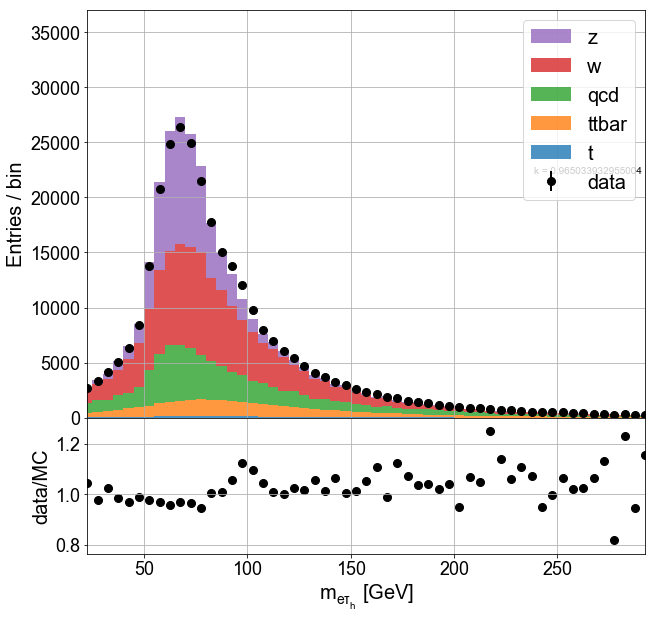

In [24]:
# test the QCD estimate
fig, axes = plt.subplots(2, 1, figsize=(10, 10), facecolor='white', gridspec_kw={'height_ratios':[3,1]}, sharex=True)
fig.subplots_adjust(hspace=0)

ax = axes[0]
x, y, yerr = pt.hist_to_errorbar(df_data_os[var], bins=bins)
eb = ax.errorbar(x, y, yerr, fmt='ko', capsize=0, elinewidth=2)
h_mc, _, _ = ax.hist([df_top_os[var], df_ttbar_os[var], df_qcd[var], df_w_os[var], df_z_os[var]], 
                     bins=bins,
                     histtype='stepfilled', 
                     alpha=0.8, 
                     stacked=True,
                     weights=[df_top_os['weight'], df_ttbar_os['weight'], df_qcd['weight'], df_w_os['weight'], df_z_os['weight']])

ax.legend(['z', 'w', 'qcd', 'ttbar', 't', 'data'])
ax.text(0.8, 0.6, f'k = {k}', transform = ax.transAxes)
ax.grid()
ax.set_ylim(0, 1.4*y.max())
ax.set_ylabel(f'Entries / bin')
ax.set_yscale('linear')

ax = axes[1]
r = y/h_mc[-1]
ax.scatter(x, r, marker='o', c='k')
ax.grid()
ax.set_xlim(x[0], x[-1])
#ax.set_ylim(0.75, 1.49)
#ax.set_xlabel(r'$\sf p_{T,\tau_{h}}$ [GeV]')
if selection == 'mutau':
    ax.set_xlabel(r'$\sf m_{\mu\tau_{h}}$ [GeV]')
elif selection == 'etau':
    ax.set_xlabel(r'$\sf m_{e\tau_{h}}$ [GeV]')
ax.set_ylabel('data/MC')

plt.savefig(f'plots/{selection}_{var}_iso.pdf')
plt.show()

## correction factor from isolation inverted region

In [25]:
if selection == 'mutau':
    datasets = [
        'muon_2016B_fakes', 'muon_2016C_fakes', 'muon_2016D_fakes',
        'muon_2016E_fakes', 'muon_2016F_fakes', 'muon_2016G_fakes',
        'muon_2016H_fakes'
    ]
elif selection == 'etau':
    datasets = [
        'electron_2016B_fakes', 'electron_2016C_fakes', 'electron_2016D_fakes',
        'electron_2016E_fakes', 'electron_2016F_fakes', 'electron_2016G_fakes',
        'electron_2016H_fakes'
    ]
        
# add MC files for prompt contamination subtraction
datasets += [
    'ttbar_inclusive_fakes',  
    't_tw_fakes', 'tbar_tw_fakes',
    'zjets_m-10to50_alt_fakes', 'zjets_m-50_alt_fakes', 
    'w1jets_fakes', 'w2jets_fakes', 'w3jets_fakes', 'w4jets_fakes'
]

dm = pt.DataManager(input_dir     = f'local_data/flatuples/fakes_only/{selection}_2016',
                    dataset_names = datasets,
                    selection     = selection,
                    period        = 2016,
                    scale         = 35.9e3,
                    cuts          = f'{cuts}'#' and n_bjets == 0  and n_jets < 2'
                                     #and p_miss_zeta - 0.85*p_vis_zeta > -25 \
                                     #and 40 < dilepton1_mass < 100'
                                     #and lepton1_mt < 40 \
                   )

df_data_os  = dm.get_dataframe('fakes').query('lepton1_q != lepton2_q')
df_ttbar_os = dm.get_dataframe('ttbar_fakes').query('lepton1_q != lepton2_q')
df_top_os   = dm.get_dataframe('t_fakes').query('lepton1_q != lepton2_q')
df_z_os     = dm.get_dataframe('zjets_fakes').query('lepton1_q != lepton2_q')
df_w_os     = dm.get_dataframe('wjets_fakes').query('lepton1_q != lepton2_q')
#df_vv_os    = dm.get_dataframe('diboson_fakes').query('lepton1_q != lepton2_q')

df_data_ss  = dm.get_dataframe('fakes').query('lepton1_q == lepton2_q').copy()
df_ttbar_ss = dm.get_dataframe('ttbar_fakes').query('lepton1_q == lepton2_q').copy()
df_top_ss   = dm.get_dataframe('t_fakes').query('lepton1_q == lepton2_q').copy()
df_z_ss     = dm.get_dataframe('zjets_fakes').query('lepton1_q == lepton2_q').copy()
df_w_ss     = dm.get_dataframe('wjets_fakes').query('lepton1_q == lepton2_q').copy()
#df_vv_ss    = dm.get_dataframe('diboson_fakes').query('lepton1_q == lepton2_q').copy()

# remove weighting of data
df_data_os.loc[:, 'weight'] = 1
df_data_ss.loc[:, 'weight'] = 1

Loading dataframes: 100%|███████████████| 16.0/16.0 [00:00<00:00, 38.9it/s]
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


191.94269978303421 206.55153842505658 281.9672641030473
162.45307014642722 108.10720767098162 195.13628148147322


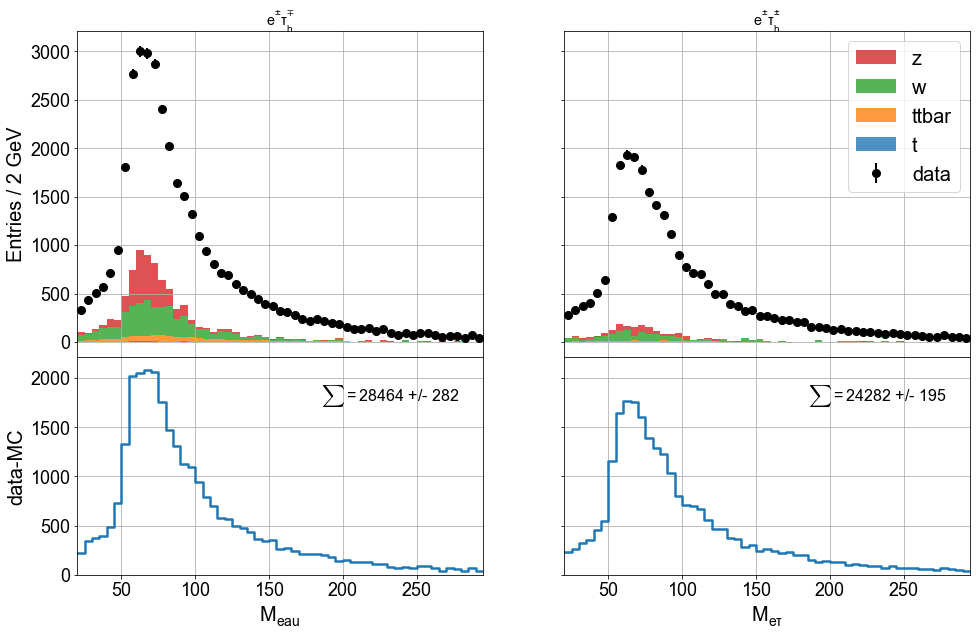

In [26]:
# compare the OS and SS control regions
fig, axes = plt.subplots(2, 2, figsize=(16, 10), facecolor='white', gridspec_kw={'height_ratios':[3,2]}, sharex='col', sharey='row')
fig.subplots_adjust(hspace=0)

ax = axes[0][0]
x, y, yerr = pt.hist_to_errorbar(df_data_os[var], bins = bins)
ax.errorbar(x, y, yerr, fmt='ko', capsize=0, elinewidth=2)
h_mc, _, _ = ax.hist([df_top_os[var], df_ttbar_os[var], df_w_os[var], df_z_os[var]], 
                     bins=bins, 
                     histtype='stepfilled', 
                     alpha=0.8, 
                     weights=[df_top_os['weight'], df_ttbar_os['weight'], df_w_os['weight'], df_z_os['weight']], 
                     stacked=True)
var_mc, _ = np.histogram(np.concatenate([df_top_os[var], df_ttbar_os[var], df_w_os[var], df_z_os[var]]), 
                     bins=bins, 
                     weights=np.concatenate([df_top_os['weight']**2, df_ttbar_os['weight']**2, df_w_os['weight']**2, df_z_os['weight']**2]), 
                     )
err_data, err_mc = np.sqrt(np.sum(yerr**2)), np.sqrt(var_mc.sum())
err_total = np.sqrt(err_data**2 + err_mc**2)
print(err_data, err_mc, err_total)

ax.grid()
ax.set_ylabel('Entries / 2 GeV')
ax.set_xlim(bins.min(), bins.max())
if selection == 'mutau':
    ax.set_title(r'$\mu^{\pm}\tau^{\mp}_{h}$', fontsize=20)
elif selection == 'etau':
    ax.set_title(r'$e^{\pm}\tau^{\mp}_{h}$')
    

ax = axes[1][0]
h_data, _ = np.histogram(df_data_os[var], bins=bins)
diff = y - h_mc[-1]
diff_os_antiiso = np.append(diff, diff[-1])
ax.plot(bins, diff_os_antiiso, drawstyle='steps-post')
ax.text(0.6, 0.8, r'$\sum =$' + f'{diff.sum():.0f} +/- {err_total:.0f}', size = 16, transform = ax.transAxes)
ax.set_ylabel('data-MC')
#ax.set_ylim(0, None)
ax.grid()

if selection == 'mutau':
    ax.set_xlabel('$M_{\mu\tau}$')
elif selection == 'etau':
    ax.set_xlabel('$M_{e\tau}$')

ax = axes[0][1]
x, y, yerr = pt.hist_to_errorbar(df_data_ss[var], bins = bins)
eb = ax.errorbar(x, y, yerr, fmt='ko', capsize=0, elinewidth=2)
h_mc, _, _ = ax.hist([df_top_ss[var], df_ttbar_ss[var], df_w_ss[var], df_z_ss[var]], 
                     bins=bins, 
                     histtype='stepfilled', 
                     alpha=0.8, 
                     weights=[df_top_ss['weight'], df_ttbar_ss['weight'], df_w_ss['weight'], df_z_ss['weight']], 
                     stacked=True
                    )

var_mc, _ = np.histogram(np.concatenate([df_top_ss[var], df_ttbar_ss[var], df_w_ss[var], df_z_ss[var]]), 
                     bins=bins, 
                     weights=np.concatenate([df_top_ss['weight']**2, df_ttbar_ss['weight']**2, df_w_ss['weight']**2, df_z_ss['weight']**2]), 
                     )
err_data, err_mc = np.sqrt(np.sum(yerr**2)), np.sqrt(var_mc.sum())
err_total = np.sqrt(err_data**2 + err_mc**2)
print(err_data, err_mc, err_total)

ax.grid()
ax.set_xlim(bins.min(), bins.max())
ax.legend(['z', 'w', 'ttbar', 't', 'data'])
if selection == 'mutau':
    ax.set_title(r'$\mu^{\pm}\tau^{\pm}_{h}$', fontsize=20)
elif selection == 'etau':
    ax.set_title(r'$e^{\pm}\tau^{\pm}_{h}$')

ax = axes[1][1]
diff = y - h_mc[-1]
diff_ss_antiiso = np.append(diff, diff[-1])
ax.plot(bins, diff_ss_antiiso, drawstyle='steps-post')
ax.text(0.6, 0.8, r'$\sum =$' + f'{diff.sum():.0f} +/- {err_total:.0f}', size = 16, transform = ax.transAxes)
ax.set_ylim(0, 1.25*diff.max())
ax.grid()

if selection == 'mutau':
    ax.set_xlabel(r'$M_{\mu\tau}$')
elif selection == 'etau':
    ax.set_xlabel(r'$M_{e\tau}$')

#plt.tight_layout()
plt.savefig(f'plots/ltau_fakes/{selection}_cr_antiiso.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


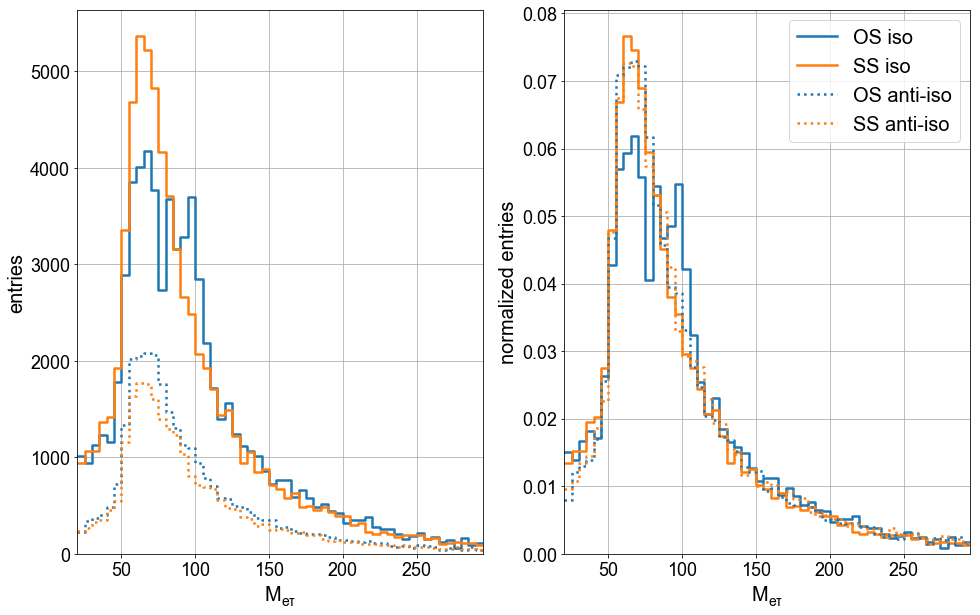

In [27]:
# overlay predictions from OS and SS regions

fig, axes = plt.subplots(1, 2, facecolor='white', figsize=(16, 10), sharex=True)

ax = axes[0]
ax.plot(bins, diff_os_iso, drawstyle='steps-post', color='C0', label='OS iso')
ax.plot(bins, diff_ss_iso, drawstyle='steps-post', color='C1', label='SS iso')
ax.plot(bins, diff_os_antiiso, drawstyle='steps-post', color='C0', linestyle=':', label='OS anti-iso')
ax.plot(bins, diff_ss_antiiso, drawstyle='steps-post', color='C1', linestyle=':', label='SS anti-iso')
ax.set_ylim(0, 1.05*np.max([diff_os_iso.max(), diff_ss_iso.max(), diff_os_antiiso.max(), diff_ss_antiiso.max()]))
ax.grid()

ax.set_xlim(bins[0], bins[-1])
ax.set_ylabel('entries')
if selection == 'mutau':
    ax.set_xlabel(r'$M_{\mu\tau}$')
elif selection == 'etau':
    ax.set_xlabel(r'$M_{e\tau}$')

ax = axes[1]
ax.plot(bins, diff_os_iso/diff_os_iso.sum(), drawstyle='steps-post', color='C0', label='OS iso')
ax.plot(bins, diff_ss_iso/diff_ss_iso.sum(), drawstyle='steps-post', color='C1', label='SS iso')
ax.plot(bins, diff_os_antiiso/diff_os_antiiso.sum(), drawstyle='steps-post', color='C0', linestyle=':', label='OS anti-iso')
ax.plot(bins, diff_ss_antiiso/diff_ss_antiiso.sum(), drawstyle='steps-post', color='C1', linestyle=':', label='SS anti-iso')
ax.set_ylim(0, None)
ax.legend()
ax.grid()

#ax = axes[1]
ax.set_xlim(bins[0], bins[-1])
ax.set_ylabel('normalized entries')
if selection == 'mutau':
    ax.set_xlabel(r'$M_{\mu\tau}$')
elif selection == 'etau':
    ax.set_xlabel(r'$M_{e\tau}$')

#plt.tight_layout()
plt.savefig(f'plots/ltau_fakes/{selection}_fake_comparison.pdf')
plt.show()